# Exploring Store Competition with Networks

In [22]:
# Packages
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import nxviz as nv 

In [23]:
# Help Functions

def extract_node_type(G: nx.Graph, node_type: str):
    # Extract a particular type of node from a graph
    nodeset = [n for n, d in G.nodes(data=True) if d["node_type"] == node_type]
    if len(nodeset) == 0:
        raise Exception(f"No nodes of node_type {node_type} exist!")
    return nodeset

## Part I: Introduction to Concepts and Application

#### Load data
Below we read the example data and transform it into nodes (with node_type customers/ shops), edges; We also add purchase_count as metadata that can be used for weights or further calculation.

Aside from the customer ID, shop ID and purchase count we also compute a metric called 'proportional_weight'. It represents the fraction of purchases a customer generated in a given shop. It is an indication of how exceptional the purchase in this shop was (i.e. 1 = 100% of purchases happened in this shop)    

In [24]:
# Load the data from the CSV
df = pd.read_csv('D:/competition_network/data/network_example.csv')

# Create an empty bipartite graph
B = nx.Graph()

# Loop through each row and calculate both the proportional weight and the absolute weight
# Group by customer to calculate the total number of purchases per customer
total_purchases_per_customer = df.groupby('customer_ID')['purchase_count'].sum()

for _, row in df.iterrows():
    customer = row['customer_ID']
    shop = row['shop_ID']
    absolute_weight = row['purchase_count']
    
    # Calculate proportional weight: purchases in this shop / total purchases by customer
    proportional_weight = absolute_weight / total_purchases_per_customer[customer]

    # Add edge with both absolute weight and proportional weight as attributes
    B.add_edge(customer, shop, absolute_weight=absolute_weight, proportional_weight=proportional_weight)

    # Add node type attributes
    B.nodes[customer]['node_type'] = 'customer'
    B.nodes[shop]['node_type'] = 'shop'


print("Bipartite graph created with", len(B.nodes), "nodes and", len(B.edges), "edges.")


Bipartite graph created with 27 nodes and 37 edges.


#### Visualize the Graph: Parellel & Hairball

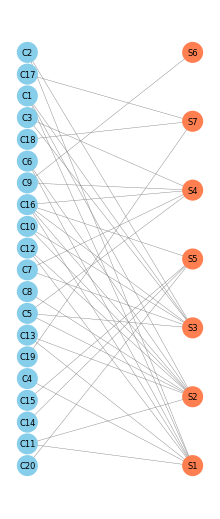

In [25]:
# Assign colors based on node type
colors = ['skyblue' if B.nodes[node].get('node_type') == 'customer' else 'coral' for node in B.nodes]

# Use bipartite layout for a clear separation of groups
top_nodes = {n for n, d in B.nodes(data=True) if d['node_type'] == 'customer'}  # Group 1
pos = nx.bipartite_layout(B, top_nodes)

# Draw the graph
plt.figure(figsize=(2, 5))
nx.draw(
    B, 
    pos, 
    with_labels=True, 
    node_color=colors, 
    node_size=200, 
    font_size=6, 
    edge_color='gray', 
    width=0.3  # Thin edges
)


# plt.title("Undirected Bipartite Graph (Customer nodes blue | Shop nodes orange)")
# output_path = r"D:/competition_network/data/bipartite_graph.png"
# plt.savefig(output_path, format='png', dpi=150, bbox_inches='tight')

plt.show()
plt.close()

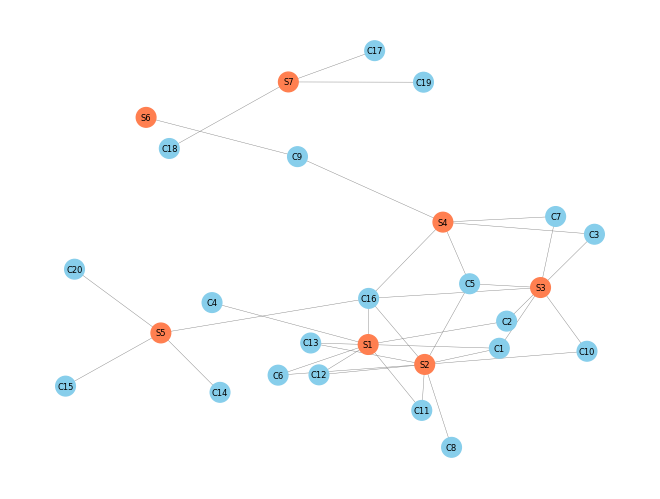

In [26]:
# Draw the graph
pos = nx.spring_layout(B, k=0.5, scale=1.5)  # Adjust 'k' for repulsion strength, 'scale' for overall size
nx.draw(B, 
    pos,
    with_labels=True, 
    node_color=colors, 
    node_size=200, 
    font_size=6,
    edge_color='gray', 
    width=0.3)

# plt.title("Hairball (Customer nodes blue | Shop nodes orange)")
# output_path = r"D:/competition_network/data/hairball.png"
# plt.savefig(output_path, format='png', dpi=150, bbox_inches='tight')

plt.show()
plt.close()

#### Projection

With ```bipartite.projected_graph(B, shop_nodes)``` function lets you create a projected graph. It makes a new graph where each node is a shop. It also makes edges between pairs of shop nodes that have at least one customer in common. Since customer nodes are turned into edges, the resulting graph only has shop nodes. 

In [27]:
# extract nodes from a particular partition
customer_nodes = extract_node_type(B, "customer")
shop_nodes = extract_node_type(B, "shop")

# compute the projection (projecting on shops)
shop_graph = bipartite.projected_graph(B, shop_nodes)

A single shared customer is enough to create an edge between two shops. However, if we would ignore the number of customers between shops, we would lose crucial information. That is, two shops that share 10 customers provide more evidence for competition than shops that have only a single customer in common. Fortunately, this information can be preserved using a weighted projection, where the number of shared customers enters the graph as an edge weight. This can be achieved with ```bipartite.weighted_projected_graph(B, shop_nodes)```.

In [28]:
# compute the weighted projection
weighted_shop_graph = bipartite.weighted_projected_graph(B, shop_nodes)

#### Visualize Adjacency Matrix and Circos Plot

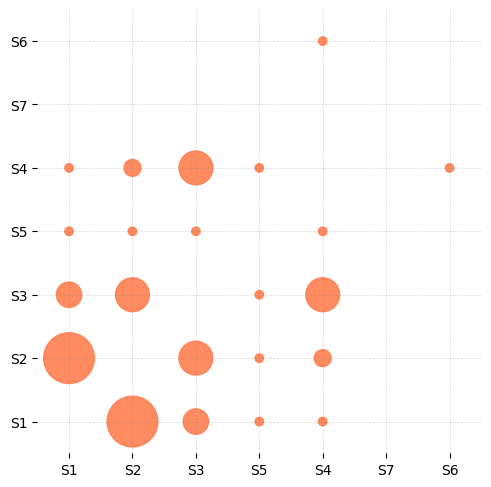

In [29]:
# Get the adjacency matrix of the weighted projected graph
adj_matrix = nx.to_numpy_array(weighted_shop_graph, weight='weight')
nodes = list(weighted_shop_graph.nodes())

fig, ax = plt.subplots(figsize=(5, 5))

# Plot each cell as a circle
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        weight = adj_matrix[i, j]
        if weight > 0:  # Only plot for non-zero weights
            circle = plt.Circle((j, i), radius=weight / np.max(adj_matrix) * 0.4, color='coral', alpha=0.9)
            ax.add_artist(circle)


ax.set_xticks(range(len(nodes)))
ax.set_yticks(range(len(nodes)))
ax.set_xticklabels(nodes)
ax.set_yticklabels(nodes)

# Gridlines 
ax.set_xlim(-0.5, len(nodes) - 0.5)
ax.set_ylim(-0.5, len(nodes) - 0.5)
ax.set_aspect('equal')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Remove black spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

# plt.title("Adjacency Matrix with Circles Representing Weights")
# output_path = r"D:/competition_network/data/circle_adjacency_matrix.png"
# plt.savefig(output_path, format='png', dpi=150)
plt.show()

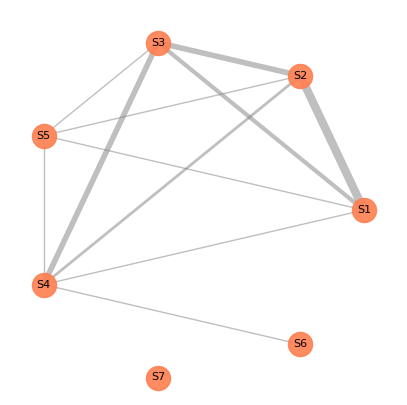

In [30]:
# Get positions for nodes in a circular layout
pos = nx.circular_layout(weighted_shop_graph)
# Get edge weights
weights = [weighted_shop_graph[u][v]['weight'] for u, v in weighted_shop_graph.edges()]


plt.figure(figsize=(5, 5))
ax = plt.gca()

nx.draw_networkx_nodes(weighted_shop_graph, pos, node_size=300, node_color='coral', alpha=0.9)
nx.draw_networkx_edges(weighted_shop_graph, pos, width=weights, edge_color='gray', alpha=0.5) 
nx.draw_networkx_labels(weighted_shop_graph, pos, font_size=8, font_color='black')
plt.axis('off')

# plt.title("Circos Plot of Weighted Projected Graph")
# output_path = r"D:/competition_network/data/circos_weighted_projection.png"
# plt.savefig(output_path, format='png', dpi=150)

plt.show()